In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
import matplotlib.pyplot as plt
import cv2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Task 1 - Data Preprocessing

In [ ]:
PATH = "D:/CV_Dataset/hw_dataset/"
df = pd.read_csv(PATH + "butterflies and moths.csv")
df.rename(columns={"class id": "class_id", "data set": "data_set"}, inplace=True)

In [ ]:
'''Удаление дубликатов и удаление None'''
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [ ]:
'''Анализ дисбаланса классов'''
def class_count_plot(df):
    class_count = df.groupby("class_id").count().iloc[:, 1].to_frame().rename(columns={"labels": "class_count"}).sort_values(by="class_count")
    class_count.plot(kind='bar', figsize=(20, 10))
    '''Коэффициент показывающий максимум дисбаланса'''
    print("Коэфициент дисбаланса: ",np.abs(class_count["class_count"].max() - class_count["class_count"].min()) / class_count["class_count"].max() * 100) # Он равен 44% => дисбаланс существенный
    ;

Коэфициент дисбаланса:  44.16243654822335


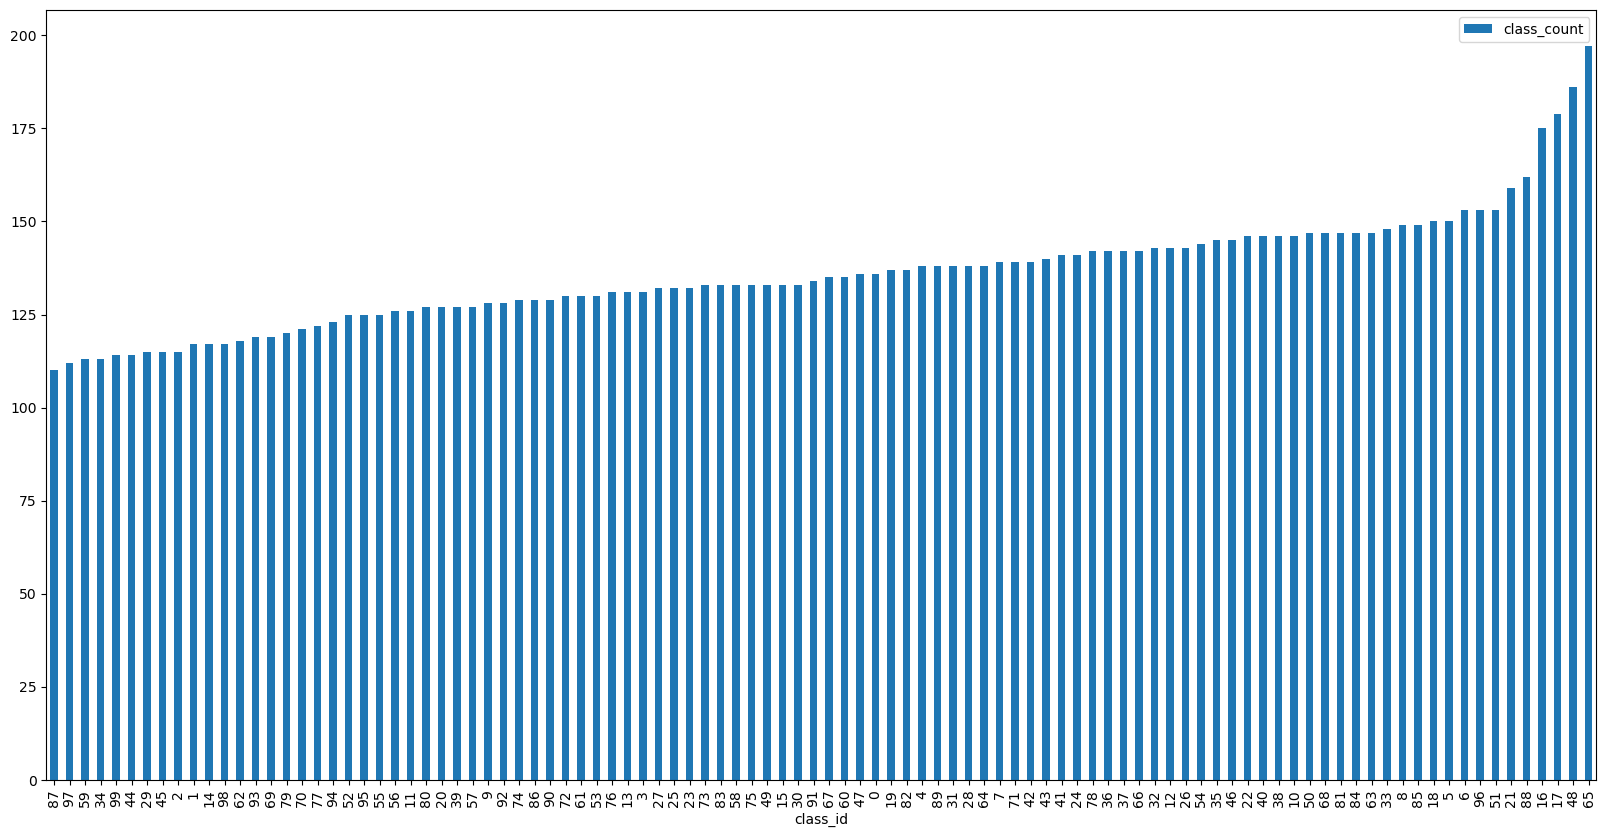

In [ ]:
class_count_plot(df)

##### Устранение дисбаланса (сэмплирование)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler #Данных много и имеет смысл сжимать данные

In [ ]:
df.shape

(13594, 4)

In [ ]:
def resampling(df):
    X = df.iloc[:, 1:]
    y = df["class_id"]
    t = RandomUnderSampler()
    X_resampled, y_resampled = t.fit_resample(X, y)
    df_new = X_resampled.join(y_resampled)
    df_new.index = range(1, len(df_new)+1)
    return df_new[df.columns]

In [ ]:
df = resampling(df)
df.shape

(11000, 4)

Коэфициент дисбаланса:  0.0


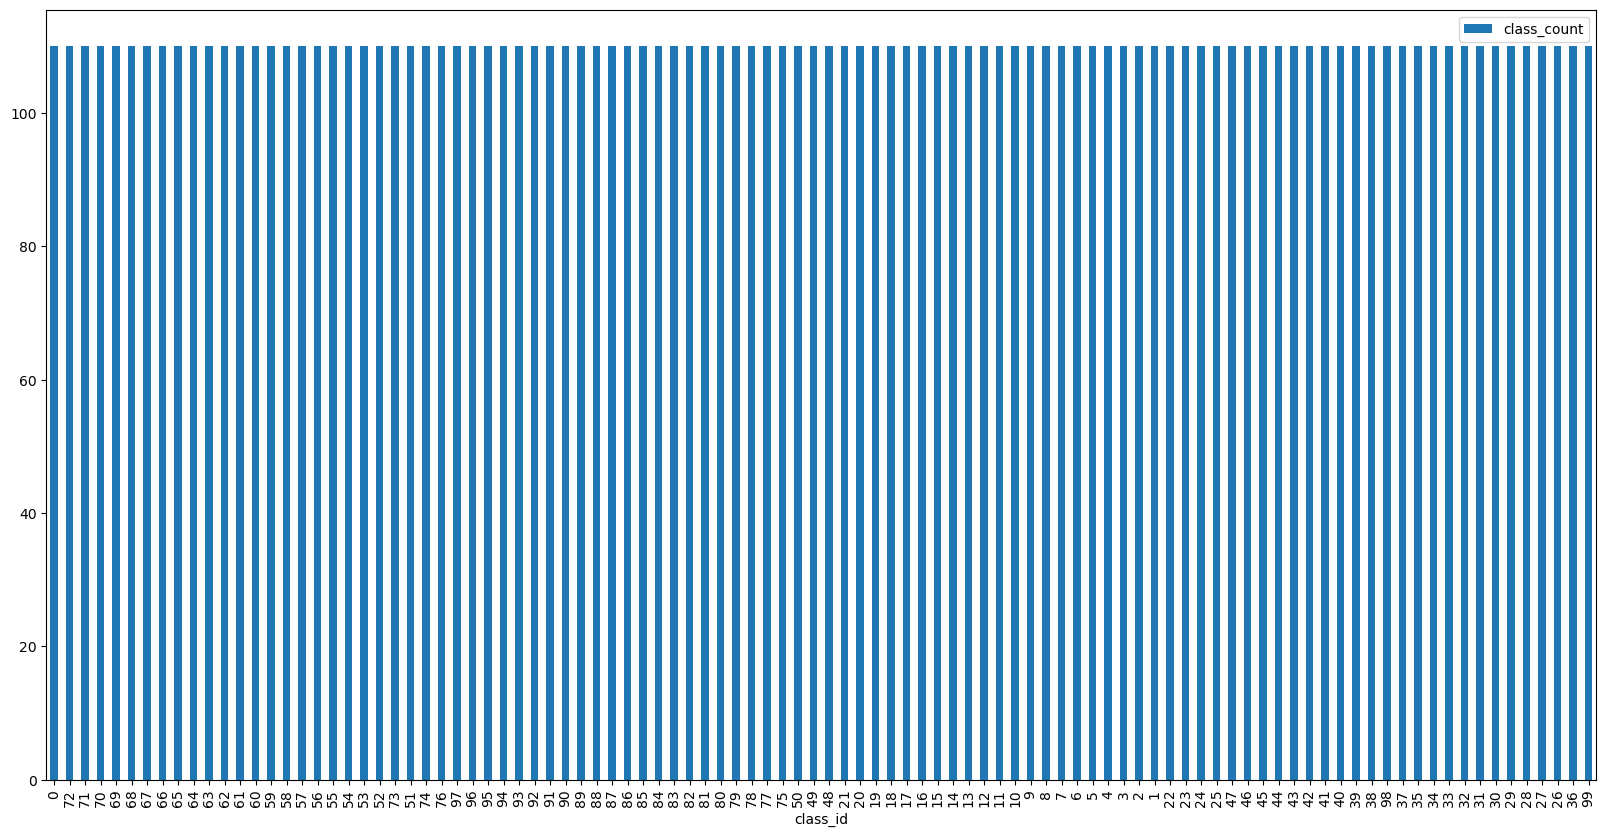

In [ ]:
class_count_plot(df)

In [ ]:
'''Анализ количества данных на test, train и valid'''
pivot_data = df.pivot_table(
    columns = "data_set",
    index = "class_id",
    values = "filepaths",
    aggfunc = "count"
)

In [ ]:
pivot_data.head()

data_set,test,train,valid
class_id,,,
0,5.0,102.0,3.0
1,4.0,102.0,4.0
2,5.0,100.0,5.0
3,5.0,100.0,5.0
4,4.0,101.0,5.0


In [ ]:
pivot_data["test"].unique(), pivot_data["valid"].unique(), pivot_data["train"].unique()

(array([5., 4., 3., 2., 1.]),
 array([ 3.,  4.,  5.,  2., nan]),
 array([102., 100., 101., 103., 104., 108., 107.]))

In [ ]:
train_data = df[df["data_set"] == "train"]
test_data = df[df["data_set"] == "test"]
valid_data = df[df["data_set"] == "valid"]

##### Анализ изображений

In [ ]:
def show_images(data, direction=PATH, num_pictures_per_line=5):
    num_rows = data.shape[0] // num_pictures_per_line
    figure, ax = plt.subplots(nrows=num_rows, ncols=num_pictures_per_line, figsize=(12, 6))
    for i, path in enumerate(data.T.loc["filepaths", :]):
        img = cv2.imread(direction + path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        name = path.split("/")[1]
        ax.ravel()[i].imshow(img_rgb)
        ax.ravel()[i].set_title(name)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show();

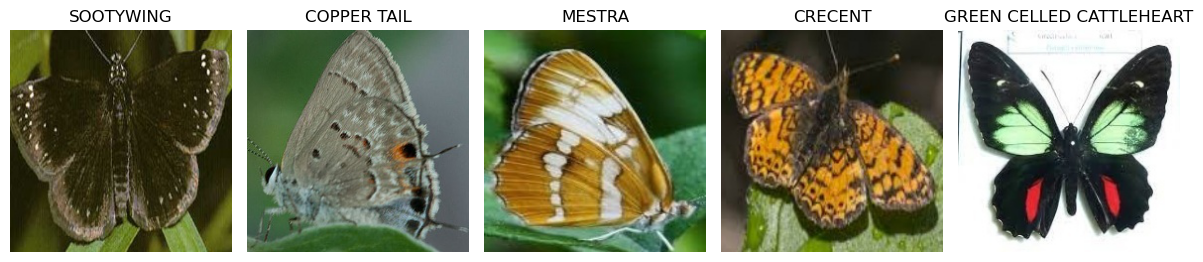

In [ ]:
show_images(df.sample(5))

##### Dataset class

In [ ]:
class MyDataSet(Dataset):
    def __init__(self, df, path=PATH, transform=None):
        self.df = df
        self.path = path
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, key):
        img_path = os.path.join(self.path, self.df.iloc[key]["filepaths"])

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image)

        label = self.df.iloc[key]["class_id"]
        if self.transform:
            image = self.transform(image)
        return image, label

##### Augmentation

In [ ]:
train_transform = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(10, 30)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = MyDataSet(train_data, transform=train_transform)
valid_dataset = MyDataSet(valid_data, transform=test_transform)
test_dataset = MyDataSet(test_data, transform=test_transform)

##### DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

##### Metrics

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [ ]:
def get_metrics(y_true, y_pred, y_pred_probabilies):
    result = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average='micro')
    }
    try:
        result["roc_auc"] = roc_auc_score(y_true, y_pred_probabilies, multi_class="ovr", average="micro")
    except ValueError:
        result["roc_auc"] = "Limit Implemention"

    return result

In [ ]:
class MetricsTable:
    def __init__(self):
        self.metrics = pd.DataFrame(columns=["model", "accuracy", "f1", "roc_auc"])

    def add_result(self, model, accuracy, f1, roc_auc):
        self.metrics.loc[len(self.metrics)] = [model, accuracy, f1, roc_auc]

    def print_table(self):
        print(self.metrics)

##### Training Loop

In [ ]:
def training_loop(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    y_pred, y_true, y_pred_probabilites = [], [], []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        predicted = predicted.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        probs = probs.detach().cpu().numpy()
        y_true.extend(labels)
        y_pred.extend(predicted)
        y_pred_probabilites.extend(probs)

    return train_loss, y_true, y_pred, y_pred_probabilites

##### Validation Loop

In [ ]:
def validation_loop(model, device, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0
    y_pred, y_true, y_pred_probabilites = [], [], []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)
            predicted = predicted.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            probs = probs.detach().cpu().numpy()
            y_true.extend(labels)
            y_pred.extend(predicted)
            y_pred_probabilites.extend(probs)

    return valid_loss, y_true, y_pred, y_pred_probabilites

##### Fit model

In [ ]:
def fit(model, device, train_loader, valid_loader, optimizer, criterion, num_epochs):
    train_losses = []
    valid_losses = []
    test_losses = []

    train_accuracies = []
    train_roc_aucs = []
    train_f1s = []

    valid_accuracies = []
    valid_roc_aucs = []
    valid_f1s = []

    for epoch in range(num_epochs):
        train_loss, train_y_true, train_y_pred, train_y_probs = training_loop(model, device, train_loader, optimizer, criterion)
        train_metrics = get_metrics(train_y_true, train_y_pred, train_y_probs)

        train_losses.append(train_loss)

        train_accuracy = train_metrics["accuracy"]
        train_accuracies.append(train_accuracy)
        train_roc_auc = train_metrics["roc_auc"]
        train_roc_aucs.append(train_roc_auc)
        train_f1 = train_metrics["f1"]
        train_f1s.append(train_f1)


        valid_loss, valid_y_true, valid_y_pred, valid_y_probs = validation_loop(model, device, valid_loader, criterion)
        valid_metrics = get_metrics(valid_y_true, valid_y_pred, valid_y_probs)


        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        valid_accuracy = valid_metrics["accuracy"]
        valid_accuracies.append(valid_accuracy)
        valid_roc_auc = valid_metrics["roc_auc"]
        valid_roc_aucs.append(valid_roc_auc)
        valid_f1 = valid_metrics["f1"]
        valid_f1s.append(valid_f1)

        if epoch % 5 == 0:
          model_save(model, "checkpoint", "D:/CV_Dataset/Checkpoints/")

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
              f'Validation Loss: {valid_loss:.4f}, Validation:\n Accuracy: {valid_accuracy:.2%}\n Roc_Auc: {valid_roc_auc}\n F1: {valid_f1:.2%}'
             )

    return model

In [ ]:
def model_save(model, name, checkpoints_dir="D:/CV_Dataset/Models/"):
    PATH = os.path.join(checkpoints_dir, f"{name}.pt")
    print(f"Saving {name} to {PATH}")
    torch.save(model.state_dict(), PATH)

def load_model(model, name, checkpoints_dir="D:/CV_Dataset/Models/"):
    PATH = os.path.join(checkpoints_dir, f"{name}.pt")
    model.load_state_dict(torch.load(PATH))
    print(f"Loading {name} from {PATH}")
    model.eval()
    return model

In [ ]:
for (X, y) in train_loader:
  print(X.shape, y.shape)
  print(X.size())
  break

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224])


## Task 2

##### Model 1

In [ ]:
from time import time

In [ ]:
#Simple MLP net

class Net(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_features, num_classes)
    def forward(self, x):
        x = x.view(-1, 3*224*224)

        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

In [ ]:
time1_start = time()
simple_model = Net(3*224*224, 50, num_classes=100)
simple_model = simple_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=0.001)
NUM_EPOCHS = 25

simple_model = fit(simple_model, device, train_loader, valid_loader, optimizer, criterion, num_epochs=NUM_EPOCHS) #Несмотря на то, что сетка имеет только 3 слоя, учится > 20 минут
model_save(simple_model, "NetModel")
time1_end = time()
print(f"running_time: {time1_end - time1_start}")

Saving checkpoint to D:/CV_Dataset/Checkpoints/checkpoint.pt
Epoch [1/25], Training Loss: 438.7880, Training Accuracy: 0.93%, Validation Loss: 13.4534, Validation:
 Accuracy: 0.99%
 Roc_Auc: Limit Implemention
 F1: 0.99%
Epoch [2/25], Training Loss: 368.3742, Training Accuracy: 1.29%, Validation Loss: 14.6972, Validation:
 Accuracy: 1.24%
 Roc_Auc: Limit Implemention
 F1: 1.24%
Epoch [3/25], Training Loss: 366.9791, Training Accuracy: 1.57%, Validation Loss: 14.0068, Validation:
 Accuracy: 0.74%
 Roc_Auc: Limit Implemention
 F1: 0.74%
Epoch [4/25], Training Loss: 366.1842, Training Accuracy: 1.69%, Validation Loss: 15.8314, Validation:
 Accuracy: 1.24%
 Roc_Auc: Limit Implemention
 F1: 1.24%
Epoch [5/25], Training Loss: 367.5585, Training Accuracy: 1.27%, Validation Loss: 15.5603, Validation:
 Accuracy: 1.49%
 Roc_Auc: Limit Implemention
 F1: 1.49%
Saving checkpoint to D:/CV_Dataset/Checkpoints/checkpoint.pt
Epoch [6/25], Training Loss: 366.1682, Training Accuracy: 1.86%, Validation Lo

##### Model 2

In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(25088, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
time2_start = time()
simple_model = SimpleClassifier(num_classes=100)
simple_model = simple_model.to(device)


NUM_EPOCHS = 10

simple_model = fit(simple_model, device, train_loader, valid_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(simple_model, "SimpleModel")
time2_end = time()
print(f"running_time: {time2_end - time2_start}")

Saving checkpoint to D:/CV_Dataset/Checkpoints/checkpoint.pt
Epoch [1/10], Training Loss: 368.5132, Training Accuracy: 0.90%, Validation Loss: 4.6180, Validation:
 Accuracy: 0.99%
 Roc_Auc: Limit Implemention
 F1: 0.99%
Epoch [2/10], Training Loss: 368.5194, Training Accuracy: 0.93%, Validation Loss: 4.6180, Validation:
 Accuracy: 0.99%
 Roc_Auc: Limit Implemention
 F1: 0.99%
Epoch [3/10], Training Loss: 368.5155, Training Accuracy: 0.94%, Validation Loss: 4.6180, Validation:
 Accuracy: 0.99%
 Roc_Auc: Limit Implemention
 F1: 0.99%
Epoch [4/10], Training Loss: 368.5234, Training Accuracy: 1.05%, Validation Loss: 4.6180, Validation:
 Accuracy: 0.99%
 Roc_Auc: Limit Implemention
 F1: 0.99%
Epoch [5/10], Training Loss: 368.5188, Training Accuracy: 1.01%, Validation Loss: 4.6180, Validation:
 Accuracy: 0.99%
 Roc_Auc: Limit Implemention
 F1: 0.99%
Saving checkpoint to D:/CV_Dataset/Checkpoints/checkpoint.pt
Epoch [6/10], Training Loss: 368.5250, Training Accuracy: 0.99%, Validation Loss: 4

##### Model 3

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNet50(nn.Module):
    def __init__(self, num_classes, freeze_features=True):
        super().__init__()
        self.base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        if freeze_features:
            for param in self.features.parameters():
                param.requires_grad = False

        enet_out_size = 2048
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output



In [ ]:
time3_start = time()
resnet = ResNet50(num_classes=100)
resnet = resnet.to(device)
def count_frozen_params(model):
    frozen, trainable = 0, 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable += 1
        else:
            frozen += 1

    print(f"Frozen: {frozen} layers, trainable: {trainable} layers")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
NUM_EPOCHS = 3

resnet = fit(resnet, device, train_loader, valid_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(resnet, "ResNet50")
time3_end = time()
print(f"running_time: ", time3_end - time3_start)

Saving checkpoint to D:/CV_Dataset/Checkpoints/checkpoint.pt
Epoch [1/3], Training Loss: 259.9239, Training Accuracy: 51.85%, Validation Loss: 2.2602, Validation:
 Accuracy: 69.73%
 Roc_Auc: Limit Implemention
 F1: 69.73%
Epoch [2/3], Training Loss: 125.1019, Training Accuracy: 81.64%, Validation Loss: 1.4221, Validation:
 Accuracy: 73.70%
 Roc_Auc: Limit Implemention
 F1: 73.70%
Epoch [3/3], Training Loss: 78.8013, Training Accuracy: 86.38%, Validation Loss: 1.1197, Validation:
 Accuracy: 79.40%
 Roc_Auc: Limit Implemention
 F1: 79.40%
Saving ResNet50 to D:/CV_Dataset/Models/ResNet50.pt
running_time:  2736.2980647087097


##### Model 4

In [ ]:
from torchvision.models import vit_b_16, vision_transformer

In [ ]:
model = vit_b_16(num_classes=100)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
NUM_EPOCHS = 5

efficient_model = fit(model, device, train_loader, valid_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(efficient_model, "VIT")

Saving checkpoint to D:/CV_Dataset/Checkpoints/checkpoint.pt
Epoch [1/5], Training Loss: 360.2868, Training Accuracy: 1.79%, Validation Loss: 4.3455, Validation:
 Accuracy: 2.48%
 Roc_Auc: Limit Implemention
 F1: 2.48%
Epoch [2/5], Training Loss: 345.6298, Training Accuracy: 3.03%, Validation Loss: 4.3638, Validation:
 Accuracy: 3.72%
 Roc_Auc: Limit Implemention
 F1: 3.72%
Epoch [3/5], Training Loss: 331.8536, Training Accuracy: 4.73%, Validation Loss: 4.1704, Validation:
 Accuracy: 5.21%
 Roc_Auc: Limit Implemention
 F1: 5.21%
Epoch [4/5], Training Loss: 329.6382, Training Accuracy: 5.19%, Validation Loss: 4.1169, Validation:
 Accuracy: 4.22%
 Roc_Auc: Limit Implemention
 F1: 4.22%
Epoch [5/5], Training Loss: 321.3823, Training Accuracy: 6.78%, Validation Loss: 4.0203, Validation:
 Accuracy: 6.95%
 Roc_Auc: Limit Implemention
 F1: 6.95%
Saving VIT to D:/CV_Dataset/Models/VIT.pt


##### Model 5

In [ ]:
from torchvision.models import resnet101

In [ ]:
model = resnet101(num_classes=100)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
NUM_EPOCHS = 5

efficient_model = fit(model, device, train_loader, valid_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(efficient_model, "Resnet101")

Saving checkpoint to D:/CV_Dataset/Checkpoints/checkpoint.pt
Epoch [1/5], Training Loss: 359.7187, Training Accuracy: 2.87%, Validation Loss: 4.5311, Validation:
 Accuracy: 2.98%
 Roc_Auc: Limit Implemention
 F1: 2.98%
Epoch [2/5], Training Loss: 313.0009, Training Accuracy: 6.15%, Validation Loss: 4.3845, Validation:
 Accuracy: 8.19%
 Roc_Auc: Limit Implemention
 F1: 8.19%
Epoch [3/5], Training Loss: 265.2003, Training Accuracy: 15.40%, Validation Loss: 3.7097, Validation:
 Accuracy: 16.38%
 Roc_Auc: Limit Implemention
 F1: 16.38%
Epoch [4/5], Training Loss: 232.7359, Training Accuracy: 24.04%, Validation Loss: 2.4384, Validation:
 Accuracy: 32.01%
 Roc_Auc: Limit Implemention
 F1: 32.01%
Epoch [5/5], Training Loss: 185.9603, Training Accuracy: 36.05%, Validation Loss: 2.2103, Validation:
 Accuracy: 41.69%
 Roc_Auc: Limit Implemention
 F1: 41.69%
Saving Resnet101 to D:/CV_Dataset/Models/Resnet101.pt


##### Model 6

In [ ]:
from torchvision.models import alexnet

In [ ]:
model = alexnet(num_classes=100)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
NUM_EPOCHS = 5

efficient_model = fit(model, device, train_loader, valid_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(efficient_model, "Alexnet")

Saving checkpoint to D:/CV_Dataset/Checkpoints/checkpoint.pt
Epoch [1/5], Training Loss: 367.0172, Training Accuracy: 1.65%, Validation Loss: 4.3005, Validation:
 Accuracy: 3.23%
 Roc_Auc: Limit Implemention
 F1: 3.23%
Epoch [2/5], Training Loss: 325.0752, Training Accuracy: 5.05%, Validation Loss: 3.9001, Validation:
 Accuracy: 8.93%
 Roc_Auc: Limit Implemention
 F1: 8.93%
Epoch [3/5], Training Loss: 280.4908, Training Accuracy: 12.20%, Validation Loss: 3.4552, Validation:
 Accuracy: 18.11%
 Roc_Auc: Limit Implemention
 F1: 18.11%
Epoch [4/5], Training Loss: 239.6030, Training Accuracy: 21.93%, Validation Loss: 2.7651, Validation:
 Accuracy: 31.76%
 Roc_Auc: Limit Implemention
 F1: 31.76%
Epoch [5/5], Training Loss: 202.5162, Training Accuracy: 32.57%, Validation Loss: 2.1631, Validation:
 Accuracy: 45.91%
 Roc_Auc: Limit Implemention
 F1: 45.91%
Saving Alexnet to D:/CV_Dataset/Models/Alexnet.pt


In [ ]:
models2checkpoints = {
    resnet101(num_classes=100): "Resnet101",
    ResNet50(num_classes=100): "ResNet50",
}

test_table = MetricsTable()

for model, checkpoint in models2checkpoints.items():
    finetuned_model = load_model(model, checkpoint)
    finetuned_model = finetuned_model.to(device)
    _, valid_y_true, valid_y_pred, valid_y_probs = validation_loop(finetuned_model, device, valid_loader, criterion)
    valid_metrics = get_metrics(valid_y_true, valid_y_pred, valid_y_probs)
    test_table.add_result(checkpoint, valid_metrics["accuracy"], valid_metrics["f1"], valid_metrics["roc_auc"])

Loading Resnet101 from D:/CV_Dataset/Models/Resnet101.pt
Loading ResNet50 from D:/CV_Dataset/Models/ResNet50.pt


In [ ]:
test_table.print_table()

       model  accuracy        f1             roc_auc
0  Resnet101  0.416873  0.416873  Limit Implemention
1   ResNet50  0.794045  0.794045  Limit Implemention


### Выводы 1:

Сравнивались две модели: resnet50 и resnet101. Несмотря на то, что resnet101 имеет более глубокую архитектуру, он показал меньший результат чем resnet50.
Причины:
1) Само построение:
    Похоже, что из resnet50 брались в основном предобученная модель с готовыми весами, а resnet101 обучалась "с нуля" (имеет смысл сравнить 2 модели обученные с нуля)
2) Переобучение:
    resnet101 имеет большую глубину, что влияет на сложность модели

In [ ]:
models2checkpoints = {
    resnet101(num_classes=100): "Resnet101",
    alexnet(num_classes=100): "Alexnet",
}

test_table = MetricsTable()

for model, checkpoint in models2checkpoints.items():
    finetuned_model = load_model(model, checkpoint)
    finetuned_model = finetuned_model.to(device)
    _, valid_y_true, valid_y_pred, valid_y_probs = validation_loop(finetuned_model, device, valid_loader, criterion)
    valid_metrics = get_metrics(valid_y_true, valid_y_pred, valid_y_probs)
    test_table.add_result(checkpoint, valid_metrics["accuracy"], valid_metrics["f1"], valid_metrics["roc_auc"])

Loading Resnet101 from D:/CV_Dataset/Models/Resnet101.pt
Loading Alexnet from D:/CV_Dataset/Models/Alexnet.pt


In [ ]:
test_table.print_table()

       model  accuracy        f1             roc_auc
0  Resnet101  0.416873  0.416873  Limit Implemention
1    Alexnet  0.459057  0.459057  Limit Implemention


### Вывод 2:

Результаты схожи так как Alexnet и Resnet имеют разную только структуру, а все остальное схожее.